# YouTube Channel Performance Analysis

## Question

How do music channels of different genre and subscriber sizes compare  with respect to building audience and viewer engagement on YouTube?

## Goal

Identify high-performing channel types and related trends that can be applied to other in-network channels and can be used to help inform broader YouTube content and A&R strategy

## Import Libraries, API Authentication & Call Set-up and Data Merge

Objectives:
- Import required libraries and write functions for YouTube API and Snowflake calls 
- From full channel data set via Snowflake, create randomized sample data set of 500 channels across 7 different genres
- Pull back channel subscriber totals via YouTube Data API and channel performance and engagement metrics via YouTube Analytics API
- Merge various data sets to allow for data analysis

In [1]:
# import required libraries
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from googleapiclient.discovery import build
import csv
from sqlalchemy import create_engine
import configparser
from sqlalchemy.dialects import registry

In [2]:
# function to authorize and pull back youtube api credentials
def youtube_authorization():
    credentials = None
    # Token.pickle stores the user's credentials from previously successful logins
    if os.path.exists('token.pickle'):
        print('Loading Credentials From File...')
        with open('token.pickle', 'rb') as token:
            credentials = pickle.load(token)
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            print('Refreshing Access Token..')
            credentials.refresh(Request())
        else:
            print('Fetching New tokens...')
            flow = InstalledAppFlow.from_client_secrets_file(
                'client_secrets.json',
                scopes=['https://www.googleapis.com/auth/youtube.readonly',
                        'https://www.googleapis.com/auth/yt-analytics.readonly',
                        'https://www.googleapis.com/auth/youtubepartner',
                        'https://www.googleapis.com/auth/yt-analytics-monetary.readonly']
            )
            flow.run_local_server(
                port=8080, prompt='consent', authorization_prompt_message=''
            )
            credentials = flow.credentials
            # save the credentials for the next run
            with open('token.pickle', 'wb') as f:
                print('Saving Credentials for Future Use...')
                pickle.dump(credentials, f)
        return(credentials)

# function to pull back channel metrics via youtube analytics api
def channel_data_pull(channels):
    with build('youtubeAnalytics', 'v2', credentials=credentials) as service:
        request = service.reports().query(
            startDate="2021-01-01",
            endDate="2021-12-31",
            dimensions="channel",
            filters=f"channel=={channels}",
            ids="contentOwner==YbGWGCIUCoaUePqGy_acMw",
            maxResults=200,
            metrics="views,estimatedMinutesWatched,subscribersGained,comments,likes,dislikes",  
            sort="-views"
        )
    response = request.execute()
    return(response)

# function to process youtube analytics api response
def create_df_from_youtube_analytics_api_response(youtube_api_response):
    columns = []
    for i in youtube_api_response.get('columnHeaders'):
        columns.append(i.get('name'))
    return(pd.DataFrame(youtube_api_response.get('rows'), columns=columns))

# function to pull back channel statistics via youtube data api
def channel_subscriber_pull(channelid):
    with build('youtube', 'v3', credentials=credentials) as service:
        request = service.channels().list(
            part='statistics',
            id=f"{channelid}",
            onBehalfOfContentOwner='YbGWGCIUCoaUePqGy_acMw',
            maxResults=50,
        )
    response = request.execute()
    return(response)

# function to process youtube data api response and create output file
def channel_subscriber_process(channel_subscriber_response):
    for i in channel_subscriber_response.get('items'):
        channel_subscriber_list.append((i.get('id'), i.get('statistics').get('subscriberCount')))
    channel_subscriber_df = pd.DataFrame(channel_subscriber_list, columns = ['channel_id', 'total_subscribers'])
    channel_subscriber_df.to_csv('output/channel-subscriber-df.csv', index=False)

In [4]:
# create empty list that's later populated by channel subscriber process function
# create empty dataframe that's later populated by channel analytics process function
channel_subscriber_list = []
youtube_analytics_df = pd.DataFrame()

In [5]:
# run youtube api credentials authorization function 
credentials=youtube_authorization()

Loading Credentials From File...
Refreshing Access Token..


In [6]:
# import full channel data set and clean up
# pull in connection string to connect to snowflake
# create file with passwords so I don't have to incorporate into python script
config = configparser.ConfigParser()
config.read('/Users/john.mccormack/Documents/Coding/Python/license_files/passwords.ini')
connection_string = config['snowflake']['connection_string']
# create engine with sqlalchemy to connect to snowflake
# registry.register('snowflake', 'snowflake.sqlalchemy', 'dialect')
engine = create_engine(connection_string, connect_args={'authenticator': 'https://wmg.okta.com/',})
# call snowflake to get back central channel list
channel_list_raw = pd.read_sql(f"""SELECT * FROM BDMO_SANDBOX.SCOTT_M.YT_CENTRAL_CHANNEL_LIST""", engine)

/opt/anaconda3/lib/python3.9/site-packages/snowflake/sqlalchemy/snowdialect.py:206: SAWarning: Dialect snowflake:snowflake will not make use of SQL compilation caching as it does not set the 'supports_statement_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Dialect maintainers should seek to set this attribute to True after appropriate development and testing for SQLAlchemy 1.4 caching support.   Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  results = connection.execute(


In [8]:
# create filtered version of channel list keeping channels linked before 2021-01-01 to ensure available data
channel_list_raw_date = channel_list_raw[channel_list_raw['linked_date'] < "2021-01-01"]

In [9]:
# create clean version of channel list keeping only channel id, public name, and genre columns
channel_list_clean = channel_list_raw_date[['channel_id', 'public_name', 'genre']]

In [10]:
# drop any rows containing null values in channel list
channel_list_clean = channel_list_clean.dropna()

In [11]:
# convert genre column values to lower case to account for inconsistent genre text
# channel data set includes different variations of what is essentially the same genre. for example, you might have channels classified as urban, hip-hop, hip hop without a hyphen, rap, US rap, etc. 
channel_list_clean['genre'] = channel_list_clean['genre'].str.lower()

In [12]:
# create filter for genre column in order to only keep the below genre values
genre_filter = channel_list_clean['genre'].isin(['pop','rock', 'urban', 'latin', 'country', 'metal', 'dance'])
channel_list_filtered = channel_list_clean[genre_filter]

In [13]:
# pull a randomized sample of 500 channels from channel list
channel_list_filtered_sample = channel_list_filtered.sample(n=500)

In [14]:
# look at value counts for genre column across randomized set of 500 channels
channel_list_filtered_sample['genre'].value_counts()

pop        187
rock       129
urban       78
dance       40
metal       26
country     23
latin       17
Name: genre, dtype: int64

In [ ]:
# export out channel_list_filtered_sample as csv to make sure channel sample remains the same for data analysis
channel_list_filtered_sample.to_csv('output/channel-list-df.csv', index=False)

In [ ]:
# read in channel_list_filtered_sample df csv
channel_list_filtered_sample= pd.read_csv('output/channel-list-df.csv')

In [16]:
# create a list of values from channel_id column for api calls
channel_ids = channel_list_filtered_sample['channel_id'].tolist()

In [17]:
# create grouping to account for youtube api result maxes 
channel_id_grouping = [channel_ids[x:x+50] for x in range(0, len(channel_ids), 50)]

In [18]:
# process youtube data api call response
for channels in channel_id_grouping:
    channel_group_string = ",".join(channels)
    channel_subscriber_response = channel_subscriber_pull(channel_group_string)
    channel_subscriber_process(channel_subscriber_response)

In [19]:
# export out channel_susbcriber_df as csv
channel_subscriber_df= pd.read_csv('output/channel-subscriber-df.csv')

In [20]:
# process youtube analytics api call response
for channels in channel_id_grouping:
    channel_group_string = ",".join(channels)
    channel_data_response = channel_data_pull(channel_group_string)
    channel_info_df = create_df_from_youtube_analytics_api_response(channel_data_response)
    youtube_analytics_df = pd.concat([youtube_analytics_df,channel_info_df],axis=0)

In [21]:
# rename channel column in channel_info_df to "channel_id" to merge with channel_subscriber_df
youtube_analytics_df = youtube_analytics_df.rename(columns={'channel':'channel_id'})

In [22]:
# export out youtube_analytics_df as csv
youtube_analytics_df.to_csv('output/youtube-analytics-df.csv', index=False)

In [23]:
# merge channel_list_filtered_sample dataframe, channel_subscriber_df, and channel_info_df on "channel_id"
full_api_data = pd.merge(channel_list_filtered_sample, youtube_analytics_df, on='channel_id', how = "left")
full_api_data_merge = pd.merge(full_api_data, channel_subscriber_df, on='channel_id', how = "left")

## Data Manipulation and Analysis

Objectives:

- Add new columnns for views/subscriber and likes vs. dislikes metrics to account for variance in channel size across channel sample data set
- Create buckets for genre, subscriber size, and combined genre/subscriber size groupby dataframes
- Perform data analysis to pull out trends and insights using genre and subscriber size bucketing

In [24]:
# add columns to calculate views/subscribers and likes/dislikes metrics
full_api_data_merge['views_subs'] = full_api_data_merge['views'] / full_api_data_merge['subscribersGained']
full_api_data_merge['likes_dislikes'] = full_api_data_merge['likes'] / full_api_data_merge['dislikes']

In [260]:
# replace inf and nan values with 0's
full_api_data_merge.replace([np.inf, -np.inf], np.nan, inplace=True)
full_api_data_merge['views_subs'] = full_api_data_merge['views_subs'].fillna(0)
full_api_data_merge['likes_dislikes'] = full_api_data_merge['likes_dislikes'].fillna(0)

In [26]:
# export out full api data merge as csv
full_api_data_merge.to_csv('output/full-api-data-merge-df.csv', index=False)

In [68]:
# check channel total subscribers max to create bucket max
full_api_data_merge['total_subscribers'].max()

22800000

In [28]:
# create subscriber bins and labels for subscriber buckets and apply to full_data_api_merge dataframe
bins = [0,10000,100000,500000,1000000,10000000, 50000000]
labels = ['0-10,000', '10,001-100,000', '100,001-500,000', '500,001-1,000,000', '1,000,001-10,000,000','10,000,001-50,000,000']
full_api_data_merge['subscriber_bucket'] = pd.cut(full_api_data_merge['total_subscribers'],bins,labels=labels)

In [227]:
# check if subscriber buckets were properly applied
full_api_data_merge.head()

,channel_id,public_name,genre,views,estimatedMinutesWatched,subscribersGained,comments,likes,dislikes,total_subscribers,views_subs,likes_dislikes,subscriber_bucket
0,UCvpHzqdDr1zvtaW8BaVegzw,oficialzodiacs,rock,16.0,2.500000e+01,3.0,0.0,0.0,0.0,22,5.333333,0.000000,"0-10,000"
1,UCYXCt3TYSfZHgxjXUVN8wTA,JXN,pop,9571.0,1.712400e+04,665.0,10.0,238.0,11.0,9380,14.392481,21.636364,"0-10,000"
2,UChOQUXRRV04p9nDJmfuX9pA,Navet,dance,285.0,3.810000e+02,1.0,0.0,5.0,0.0,28,285.000000,0.000000,"0-10,000"
3,UCHpttVC36T04Tt6CFTk04xg,chiodos,metal,4808.0,4.914000e+03,4435.0,9.0,84.0,4.0,31100,1.084104,21.000000,"10,001-100,000"
4,UCnSR7_Oq-MdsZxfogsfk-Ug,Tommy Boy,urban,522052670.0,1.463708e+09,677196.0,137116.0,5014420.0,151296.0,1970000,770.903357,33.143110,"1,000,001-10,000,000"


In [231]:
# create individual groupby genre and subscriber bucket dataframes adding in channel_id count column
genre_groupby_df = full_api_data_merge.groupby(['genre']).agg({'channel_id': 'count','views': 'sum','estimatedMinutesWatched': 'sum','total_subscribers': 'sum','subscribersGained': 'sum','comments': 'sum','likes': 'sum','dislikes': 'sum','views_subs': 'mean','likes_dislikes': 'mean'})
subscriber_groupby_df = full_api_data_merge.groupby(['subscriber_bucket']).agg({'channel_id': 'count','views': 'sum','estimatedMinutesWatched': 'sum','total_subscribers': 'sum','subscribersGained': 'sum','comments': 'sum','likes': 'sum','dislikes': 'sum','views_subs': 'mean','likes_dislikes': 'mean'})

In [232]:
# create combined groupby genre and subscriber bucket dataframe adding in channel_id count column and replacing nan vlues with 0's
genre_subscriber_bucket_groupby_df = full_api_data_merge.groupby(['genre','subscriber_bucket']).agg({'channel_id': 'count','views': 'sum','estimatedMinutesWatched': 'sum','total_subscribers': 'sum','subscribersGained': 'sum','comments': 'sum','likes': 'sum','dislikes': 'sum','views_subs': 'mean','likes_dislikes': 'mean'})
genre_subscriber_bucket_groupby_df['views_subs'] = genre_subscriber_bucket_groupby_df['views_subs'].fillna(0)
genre_subscriber_bucket_groupby_df['likes_dislikes'] = genre_subscriber_bucket_groupby_df['likes_dislikes'].fillna(0)

In [ ]:
# check various groupby comparisons
genre_groupby_df
subscriber_groupby_df
genre_subscriber_bucket_groupby_df.head()

# Data Visualization

Objectives:

- Plot graphs highlighting insights from data analysis
- Example graphs include: 
    - Distribution of channels in sample data set by genre
    - Distribution of channels in sample data set by subscriber size
    - Views/subscriber and likes vs. dislikes comparison by genre

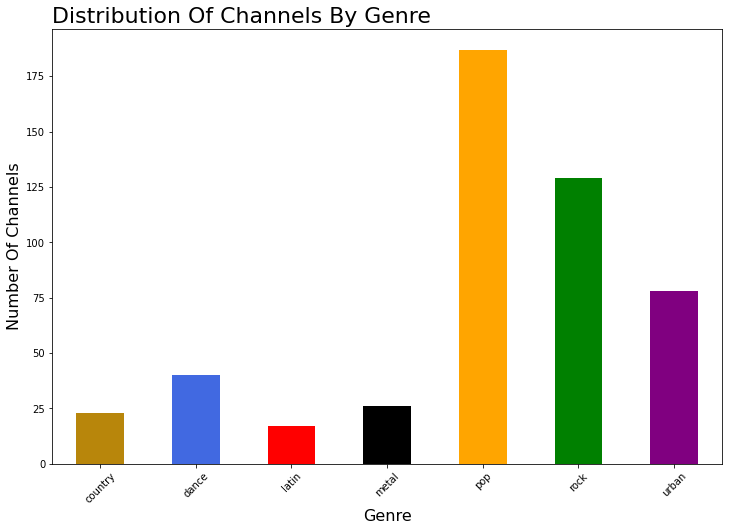

In [257]:
# plot bar graph highlighting distribution of channels in channel sample by genre

full_api_data_merge['genre'].value_counts().sort_index().plot(
    kind='bar', 
    color=['darkgoldenrod', 'royalblue', 'red', 'black', 'orange', 'green', 'purple'],
    figsize=(12, 8)
)
plt.xlabel('Genre', size =16)
plt.ylabel('Number Of Channels', size = 16)
plt.title('Distribution Of Channels By Genre', loc='left', size = 22)
plt.xticks(rotation=45);
plt.savefig('output/channel-distribution-by-genre-graph.png', dpi=192)

## Insights

- The above bar graph gives you a visual representation of the distribution of channels within the sample set by genre.
- Pop genre channels comprise the largest proportion of the randomized sample, followed by Rock and then Urban channels. 
- Overall, I think this is a fairly close representation of the network at-large, though I do think that Urban, for example, would skew higher if not for the multiple genre values challenge I mentioned earlier.

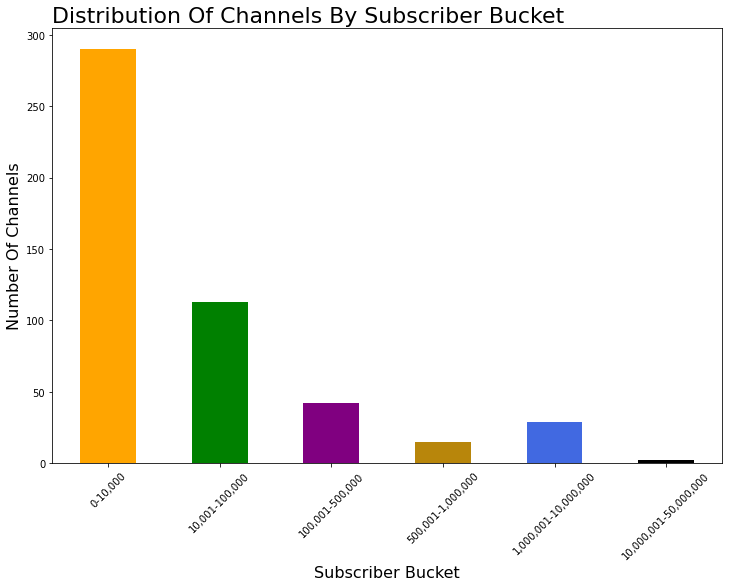

In [258]:
# plot bar graph highlighting distribution of channels in channel sample by subscriber size

full_api_data_merge['subscriber_bucket'].value_counts().sort_index().plot(
    kind='bar', 
    color=['orange','green','purple', 'darkgoldenrod', 'royalblue', 'black'],
    figsize=(12, 8)
)
plt.xlabel('Subscriber Bucket', size = 16)
plt.ylabel('Number Of Channels', size = 16)
plt.title('Distribution Of Channels By Subscriber Bucket', loc='left', size=22)
plt.xticks(rotation=45);
plt.savefig('output/channel-distribution-by-subscriber-bucket-graph.png', dpi=192)

## Insights

- The above bar graph gives you a visual representation of the distribution of channels within the sample set by subscriber size.
- The higher you go up in size like the 1-10M and 10-50M buckets, you’re naturally going to be looking at a smaller group of channels. 
- Overall, I think this is a fairly close representation of the network at-large, though I do think that the 0-10,000 subscriber bucket might not skew quite as high at a network level. 

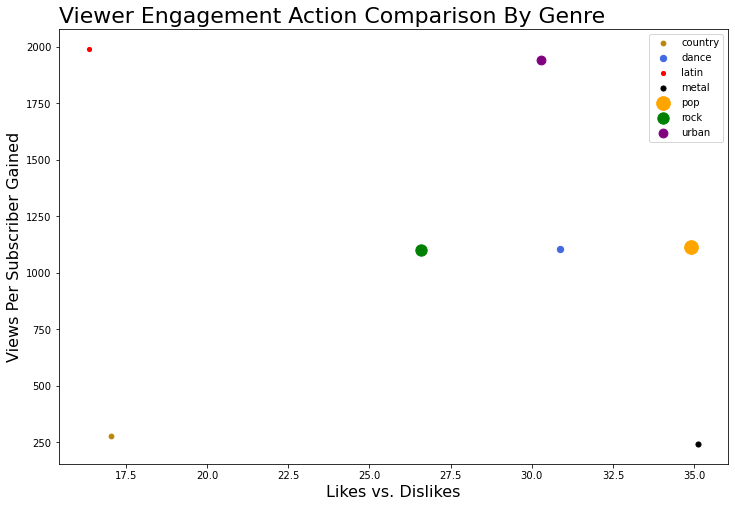

In [267]:
# plot scatter highlighting relationship between views per subscriber added and likes vs. dislikes ratio by genre

fig, ax = plt.subplots()

colors = {'country':'darkgoldenrod', 'dance':'royalblue', 'latin':'red', 'metal':'black', 'pop':'orange', 
          'rock': 'green', 'urban': 'purple'}

genre_comp = genre_groupby_df.groupby('genre')
for key, group in genre_comp:
    group.plot(ax=ax, kind='scatter', s = 'channel_id', x='likes_dislikes', y='views_subs', 
    label=key, color=colors[key], figsize=(12, 8))

plt.title('Viewer Engagement Action Comparison By Genre',size = 22, loc = 'left')
plt.xlabel('Likes vs. Dislikes', size = 16)
plt.ylabel('Views Per Subscriber Gained', size = 16) 
plt.savefig('output/viewspersub-likesvsdislikes-genre-graph.png', dpi=192)
plt.show()

## Insights


- This graph shows you a comparison of the two calculated performance metrics I added - views per subscriber gained and likes vs. dislikes ratio – both by genre.

- Views per subscriber added is the number of views it takes for the channel to add a subscriber. Ideally, you want this figure to be low as it would indicate that the channel is good at converting casual viewers to subscribers. 

- Likes vs. dislikes ratio is simply the ratio between viewer likes and dislikes on the channel’s content. Ideally, you want this figure to be high as it would indicate that viewers are liking what they are seeing at a much higher rate than they are disliking or thumbs downing it. 

- Overall, I think the expected relationship would be something like the genre dots following a diagonal trend line from top left to bottom right. If you’re getting more likes, then, on the surface, it would take fewer views for the channel to add a subscriber. Conversely, if you’re getting more dislikes, then it would take more views to add a subscriber. However, that’s not really the relationship we’re seeing across the genre buckets within the channel sample.

- Pop, which comprises the highest proportion of channels in the sample, has a very high likes vs. dislikes ratio, but an average views per subscriber gained figure, which makes sense. In general, pop videos tend to see a high volume of views overall on YouTube, but those views tend to be very general in nature. Pop videos, particularly really popular ones, tend to be surfaced in areas on YouTube that a very broad, more casual audience would traffic, and I think that this dynamic is playing out in the Pop genre channels needing more views to convert a viewer to a subscriber.

- If you look at some of the more niche genres like Metal and Country, they both have very low views per subscriber added figures, which I think speaks to the fact that, though they tend to have smaller audiences, the bond between fan and artist or channel and within their respective communities tends to be stronger, resulting in a better views per subscribers added value than a genre like Pop.

- More specifically, the Country genre has both a low views per subscriber added figure (which you want to be low) and a low likes vs. dislikes ratio (which you want to be high), which I think might speak to a tendency on the part Country music fans to subscribe to a channel as a first positive viewer action in comparison to liking a video. 

- The last thing I want to quickly highlight is around the Metal genre, which, among the 7 genres represented in the channel sample, outperforms in both metrics. It has not only a very high likes vs. dislikes ratio, but also a very low views per subscriber added value. I’d like to perform this analysis across all of the metal channels within the network to see if the trend holds overall, but it’s very impressive.
